<a href="https://colab.research.google.com/github/jaredlan1/getting_started_with_ML/blob/main/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.stats import qmc
import re
from google.colab import drive

np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [5]:
data_path = '/content/drive/MyDrive/Physics Informed ML/HW/hw_4_data_format.txt'

data = np.loadtxt(data_path, delimiter=None)

print("Raw data shape:", data.shape)

# Split columns
x_data = data[:, [0]]
t_data = data[:, [1]]
u_data = data[:, [2]]

print("x range:", x_data.min(), x_data.max())
print("t range:", t_data.min(), t_data.max())
print("u range:", u_data.min(), u_data.max())

Raw data shape: (5050, 3)
x range: -1.0 1.0
t range: 0.0 1.0
u range: -0.9730845470709678 0.9860665614647114


In [8]:
dtype = torch.float32

def to_tensor(a, requires_grad=False):
  return torch.tensor(a, dtype=dtype, device=device, requires_grad=requires_grad)

x_u = to_tensor(x_data, requires_grad=True)
t_u = to_tensor(t_data, requires_grad=True)
u_u = to_tensor(u_data, requires_grad=True)

N_f = 10000 # collocation points
sampler = qmc.LatinHypercube(d=2, seed=0)
Xf = sampler.random(n=N_f)

x_f_np = 2.0 * Xf[:, [0]]-1.0
t_f_np = 1.0 * Xf[:,[1]]

x_f_all = to_tensor(x_f_np, requires_grad=False)
t_f_all = to_tensor(t_f_np, requires_grad=False)

print("x_u,t_u,u_u:", x_u.shape, t_u.shape, u_u.shape)
print("x_f_all,t_f_all:", x_f_all.shape, t_f_all.shape)


x_u,t_u,u_u: torch.Size([5050, 1]) torch.Size([5050, 1]) torch.Size([5050, 1])
x_f_all,t_f_all: torch.Size([10000, 1]) torch.Size([10000, 1])


In [9]:
class PINN(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList()
    for i in range(len(layers) - 1):
        self.layers.append(nn.Linear(layers[i], layers[i+1]))

    for m in self.layers:
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

  def forward(self, x, t):
    z=torch.cat([x, t], dim=1)
    for i, layer in enumerate(self.layers):
        z=layer(z)
        if i < len(self.layers)-1:
            z=torch.tanh(z)

    return z


model = PINN([2,64,64,64,64,1]).to(device).to(dtype)

lambda1 = nn.Parameter(torch.tensor([1.0], dtype=dtype, device=device))
lambda2 = nn.Parameter(torch.tensor([-0.01/np.pi], dtype=dtype, device=device))

print("Initial lambda1, lambda2:", lambda1.item(), lambda2.item())

Initial lambda1, lambda2: 1.0 -0.0031830989755690098


In [11]:
def burguers_residual(x, t):
  # f= u_t + lambda1 * u * u_x + lambda2 * u_xx

  u = model(x, t )
  ones = torch.ones_like(u)

  u_t = torch.autograd.grad(u , t, grad_outputs=ones ,
                            create_graph=True, retain_graph=True)[0]

  u_x = torch.autograd.grad(u, x, grad_outputs=ones,
                            create_graph=True, retain_graph=True)[0]

  u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                             create_graph=True, retain_graph=True)[0]

  f= u_t + lambda1 * u * u_x + lambda2* u_xx

  return f



In [14]:
lr = 1e-3
epochs = 5000
batch_f = 2000

optimizer = torch.optim.Adam(list(model.parameters()) + [lambda1, lambda2], lr=lr)

loss_hist, loss_u_hist, lost_f_hist = [],[],[]

for ep in range(1, epochs +1):
    optimizer.zero_grad(set_to_none=True)

    u_pred = model(x_u, t_u)
    loss_u = torch.mean((u_pred - u_u)**2)

    idx = torch.randint(0, N_f, (batch_f,), device=device)
    x_f = x_f_all[idx].clone().detach().requires_grad_(True)
    t_f = t_f_all[idx].clone().detach().requires_grad_(True)

    f_pred = burguers_residual(x_f, t_f)

    loss_f = torch.mean(f_pred **2)


    loss = loss_u + loss_f
    loss.backward()
    optimizer.step()

    loss_hist.append(loss.item())
    loss_u_hist.append(loss_u.item())
    lost_f_hist.append(loss_f.item())

    if ep% 500 ==0 or ep ==1:
      print(f"epoch {ep:5d} | loss {loss.item():.3e} | loss_u {loss_u.item():.3e} | loss_f {loss_f.item():.3e} "
            f"| lambda1 {lambda1.item():+.4f} | lambda2 {lambda2.item():+.6f}"
        )
print("Final lambda1, lambda2:", lambda1.item(), lambda2.item())


epoch     1 | loss 3.268e-01 | loss_u 3.265e-01 | loss_f 3.240e-04 | lambda1 +0.9970 | lambda2 -0.002183
epoch   500 | loss 1.809e-02 | loss_u 1.338e-02 | loss_f 4.712e-03 | lambda1 +0.6740 | lambda2 -0.013910
epoch  1000 | loss 9.162e-03 | loss_u 7.480e-03 | loss_f 1.682e-03 | lambda1 +0.6729 | lambda2 -0.010272
epoch  1500 | loss 6.518e-03 | loss_u 5.162e-03 | loss_f 1.356e-03 | lambda1 +0.7304 | lambda2 -0.009364
epoch  2000 | loss 4.596e-03 | loss_u 3.827e-03 | loss_f 7.691e-04 | lambda1 +0.7792 | lambda2 -0.008751
epoch  2500 | loss 3.884e-03 | loss_u 2.787e-03 | loss_f 1.097e-03 | lambda1 +0.8150 | lambda2 -0.007963
epoch  3000 | loss 3.905e-03 | loss_u 2.735e-03 | loss_f 1.169e-03 | lambda1 +0.8276 | lambda2 -0.007878
epoch  3500 | loss 2.370e-03 | loss_u 2.023e-03 | loss_f 3.474e-04 | lambda1 +0.8482 | lambda2 -0.007399
epoch  4000 | loss 2.243e-03 | loss_u 1.825e-03 | loss_f 4.181e-04 | lambda1 +0.8591 | lambda2 -0.007308
epoch  4500 | loss 1.946e-03 | loss_u 1.472e-03 | loss_

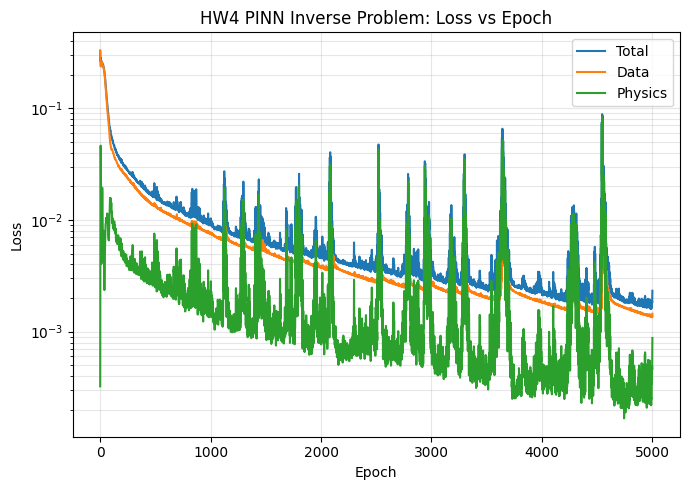

In [16]:
epochs_arr = np.arange(1, len(loss_hist) + 1)

plt.figure(figsize=(7,5))
plt.semilogy(epochs_arr, loss_hist, label="Total")
plt.semilogy(epochs_arr, loss_u_hist, label="Data")
plt.semilogy(epochs_arr, lost_f_hist, label="Physics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("HW4 PINN Inverse Problem: Loss vs Epoch")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


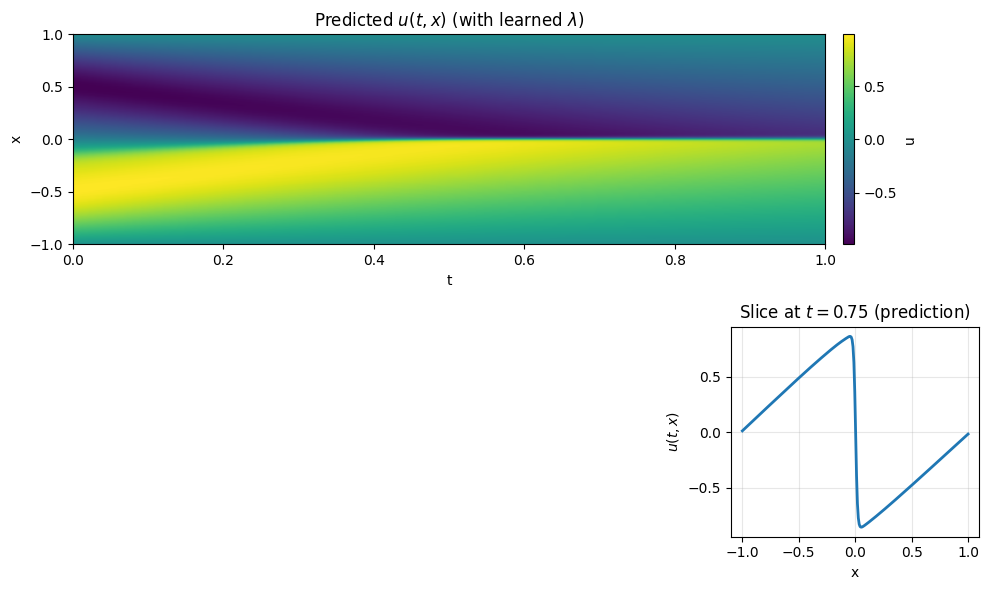

Learned lambda1, lambda2: 0.8865824341773987 -0.006779158022254705
Target (approx): lambda1=1, lambda2=-0.01/pi = -0.003183098861837907


In [17]:
model.eval()

nx, nt = 256, 101
xg = np.linspace(-1, 1, nx)
tg = np.linspace(0, 1, nt)
T, X = np.meshgrid(tg, xg)  # (nx, nt)

with torch.no_grad():
    X_t = to_tensor(X.reshape(-1,1), requires_grad=False)
    T_t = to_tensor(T.reshape(-1,1), requires_grad=False)
    U_pred = model(X_t, T_t).detach().cpu().numpy().reshape(nx, nt)

t_slice = 0.75
with torch.no_grad():
    x_slice_t = to_tensor(xg[:, None], requires_grad=False)
    t_slice_t = to_tensor((t_slice*np.ones((nx,1))), requires_grad=False)
    u_slice_pred = model(x_slice_t, t_slice_t).detach().cpu().numpy().ravel()

fig = plt.figure(figsize=(10, 6))

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
im = ax1.imshow(
    U_pred,
    aspect="auto",
    origin="lower",
    extent=[tg.min(), tg.max(), xg.min(), xg.max()],
)
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax1.set_title("Predicted $u(t,x)$ (with learned $\\lambda$)")
cbar = plt.colorbar(im, ax=ax1, pad=0.02)
cbar.set_label("u")

ax2 = plt.subplot2grid((2, 3), (1, 2))
ax2.plot(xg, u_slice_pred, linewidth=2)
ax2.set_title(rf"Slice at $t={t_slice}$ (prediction)")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$u(t,x)$")
ax2.grid(True, alpha=0.3)

plt.subplot2grid((2, 3), (1, 0)).axis("off")
plt.subplot2grid((2, 3), (1, 1)).axis("off")

plt.tight_layout()
plt.show()

print("Learned lambda1, lambda2:", lambda1.item(), lambda2.item())
print("Target (approx): lambda1=1, lambda2=-0.01/pi =", -0.01/np.pi)